In [1]:
import optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, confusion_matrix, roc_curve, auc

C:\Users\gonca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Logistic Regression

`Overview`: Logistic Regression models the probability of a binary outcome based on one or more predictor variables. It estimates the relationship between the dependent variable and independent variables using a logistic function.

This notebook implements a comprehensive pipeline to optimize and evaluate a logistic regression model for our predictions.

A custom `Optuna` objective function is defined to tune hyperparameters for logistic regression. These include regularization strength (C), solver type, penalty type (e.g., l1, l2, elasticnet), and the number of features to select (n_features_to_select). Invalid hyperparameter combinations (e.g., lbfgs solver with l1 penalty) are skipped.

An Optuna study is created and run for 50 trials to maximize cross-validated accuracy. The best hyperparameters and corresponding accuracy are displayed.

`Recursive Feature Elimination` (RFE) is performed to select the optimal subset of features for each trial.

Using the best hyperparameters, the logistic regression model is retrained with RFE-selected features. The most important features are identified and sorted based on the absolute value of their coefficients.

The final model is evaluated using stratified k-fold cross-validation on multiple metrics, including accuracy, precision, recall, F1-score, ROC AUC, and the custom specificity metric. Mean and standard deviation for each metric are calculated and displayed.

In [2]:
# Load the dataset
dataset = pd.read_csv('../../cleaned_data/dataset.csv')

# Prepare features and label data
label = 'PlayoffNextSeason'
features = [col for col in dataset.columns if col != label]

X = dataset[features]
y = dataset[label]

# Handle missing values
X = X.fillna(X.mean())

# Scale the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [3]:
def specificity_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    return tn / (tn + fp)

# Define the objective function for Optuna with RFE
def objective(trial):
    # Suggest hyperparameters
    C = trial.suggest_float('C', 0.01, 10, log=True)
    solver = trial.suggest_categorical('solver', ['liblinear', 'lbfgs', 'newton-cg', 'saga'])
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet'])
    
    # Suggest l1_ratio only for elasticnet
    l1_ratio = None
    if penalty == 'elasticnet':
        l1_ratio = trial.suggest_float('l1_ratio', 0.0, 1.0)
    
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    n_features_to_select = trial.suggest_int('n_features_to_select', 1, len(features))

    # Skip invalid combinations
    if solver in ['lbfgs', 'newton-cg'] and penalty == 'l1':
        return float('-inf')
    if solver == 'liblinear' and penalty == 'elasticnet':
        return float('-inf')
    if penalty == 'elasticnet' and solver != 'saga':
        return float('-inf')

    # Create the base logistic regression model with a fixed random state
    base_model = LogisticRegression(
        C=C,
        solver=solver,
        penalty=penalty,
        max_iter=max_iter,
        l1_ratio=l1_ratio,
        random_state=42
    )

    # Perform RFE for feature selection
    rfe = RFE(estimator=base_model, n_features_to_select=n_features_to_select)
    X_selected = rfe.fit_transform(X, y)

    # Perform stratified k-fold cross-validation on selected features (consistent random_state)
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    cv_scores = cross_val_score(base_model, X_selected, y, cv=skf, scoring='accuracy', error_score='raise')

    # Return the mean accuracy as the objective value
    return np.mean(cv_scores)

# Create an Optuna study and optimize
study = optuna.create_study(direction='maximize', study_name="Logistic Regression with RFE Optimization")
study.optimize(objective, n_trials=50)

[I 2024-12-20 21:15:10,916] A new study created in memory with name: Logistic Regression with RFE Optimization


[I 2024-12-20 21:15:11,098] Trial 0 finished with value: 0.7885714285714287 and parameters: {'C': 0.1418919271975889, 'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 894, 'n_features_to_select': 20}. Best is trial 0 with value: 0.7885714285714287.
[I 2024-12-20 21:15:11,132] Trial 1 finished with value: 0.7042857142857143 and parameters: {'C': 0.018200595341678255, 'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 830, 'n_features_to_select': 37}. Best is trial 0 with value: 0.7885714285714287.
[I 2024-12-20 21:15:11,134] Trial 2 finished with value: -inf and parameters: {'C': 0.02820929181394833, 'solver': 'newton-cg', 'penalty': 'l1', 'max_iter': 819, 'n_features_to_select': 16}. Best is trial 0 with value: 0.7885714285714287.
[I 2024-12-20 21:15:11,236] Trial 3 finished with value: 0.7885714285714285 and parameters: {'C': 7.17076162344678, 'solver': 'newton-cg', 'penalty': 'l2', 'max_iter': 652, 'n_features_to_select': 34}. Best is trial 0 with value: 0.7885714285714287.
[I 2024-1

In [4]:
# Display the best parameters
print("\nBest parameters:")
print(study.best_params)
print(f"Best cross-validated accuracy from Optuna: {study.best_value:.4f}")

# Retrieve best parameters
best_params = study.best_params
best_model = LogisticRegression(
    C=best_params['C'],
    solver=best_params['solver'],
    penalty=best_params['penalty'],
    max_iter=best_params['max_iter'],
    l1_ratio=best_params.get('l1_ratio'),
    random_state=42
)


Best parameters:
{'C': 0.6940209665265641, 'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 469, 'n_features_to_select': 21}
Best cross-validated accuracy from Optuna: 0.8171


In [5]:
# Display the best parameters
print("\nBest parameters:")
print(study.best_params)
print(f"Best cross-validated accuracy: {study.best_value:.4f}")

# Train the best model with the best parameters and selected features
best_params = study.best_params
best_model = LogisticRegression(
    C=best_params['C'],
    solver=best_params['solver'],
    penalty=best_params['penalty'],
    max_iter=best_params['max_iter'],
    l1_ratio=best_params.get('l1_ratio')
)


Best parameters:
{'C': 0.6940209665265641, 'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 469, 'n_features_to_select': 21}
Best cross-validated accuracy: 0.8171


In [6]:
# Perform RFE with the best number of features
rfe = RFE(estimator=best_model, n_features_to_select=best_params['n_features_to_select'])
X_selected = rfe.fit_transform(X, y)
selected_features = [features[i] for i in range(len(features)) if rfe.support_[i]]
print(f"Selected Features: {selected_features}")

# Train the final model on selected features
best_model.fit(X_selected, y)

Selected Features: ['Rank', 'PlayoffProgScore', 'W', 'WIN%', 'MIN', '3PM', '3P%', 'FTM', 'FTA', 'DREB', 'AST', 'STL', 'BLK', 'BLKA', 'DEFRTG', 'OREB%', 'DREB%', 'REB%', 'CumulativePlayoffProgScore', 'AvgPIE_NextYearPlayers', 'Performance_NextYearCoach']


LogisticRegression(C=0.6940209665265641, max_iter=469)


Feature Importance After RFE:
                       Feature  Coefficient  Absolute Importance
1             PlayoffProgScore     1.561897             1.561897
19      AvgPIE_NextYearPlayers     1.257431             1.257431
0                         Rank     1.149944             1.149944
16                       DREB%     0.660428             0.660428
20   Performance_NextYearCoach    -0.589818             0.589818
8                          FTA    -0.542267             0.542267
2                            W     0.518117             0.518117
18  CumulativePlayoffProgScore     0.498080             0.498080
17                        REB%     0.413293             0.413293
3                         WIN%     0.326995             0.326995
12                         BLK     0.315831             0.315831
7                          FTM    -0.311097             0.311097
4                          MIN     0.301114             0.301114
14                      DEFRTG     0.280363             0.2

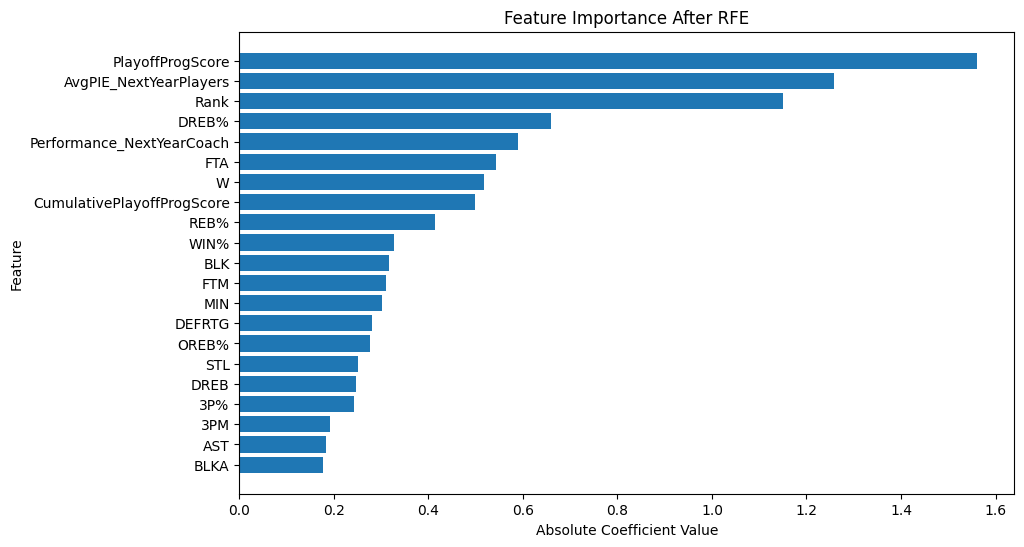

In [7]:
# Get feature importance
coefficients = best_model.coef_[0]
feature_importance = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': coefficients,
    'Absolute Importance': np.abs(coefficients)
}).sort_values(by='Absolute Importance', ascending=False)

print("\nFeature Importance After RFE:")
print(feature_importance)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Absolute Importance'])
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance After RFE')
plt.gca().invert_yaxis()
plt.show()

In [8]:
# Evaluate the final model on multiple metrics with fixed random state for CV
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc',
    'specificity': make_scorer(specificity_score)
}

final_skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_results = cross_validate(best_model, X_selected, y, cv=final_skf, scoring=scoring)

# Print results
print("\nEvaluation metrics for the final model:")
for metric in scoring.keys():
    scores = cv_results[f'test_{metric}']
    print(f"{metric.capitalize()} - Mean: {np.mean(scores):.4f}, Std: {np.std(scores):.4f}")

# For direct comparison, print the final accuracy again using the same CV as in the objective
final_cv_scores = cross_val_score(best_model, X_selected, y, cv=final_skf, scoring='accuracy')
print(f"\nFinal cross-validated accuracy (with best params): {np.mean(final_cv_scores):.4f}")


Evaluation metrics for the final model:
Accuracy - Mean: 0.8171, Std: 0.0779
Precision - Mean: 0.8470, Std: 0.1205
Recall - Mean: 0.8036, Std: 0.1440
F1 - Mean: 0.8110, Std: 0.0866
Roc_auc - Mean: 0.8457, Std: 0.0836
Specificity - Mean: 0.8304, Std: 0.1543

Final cross-validated accuracy (with best params): 0.8171


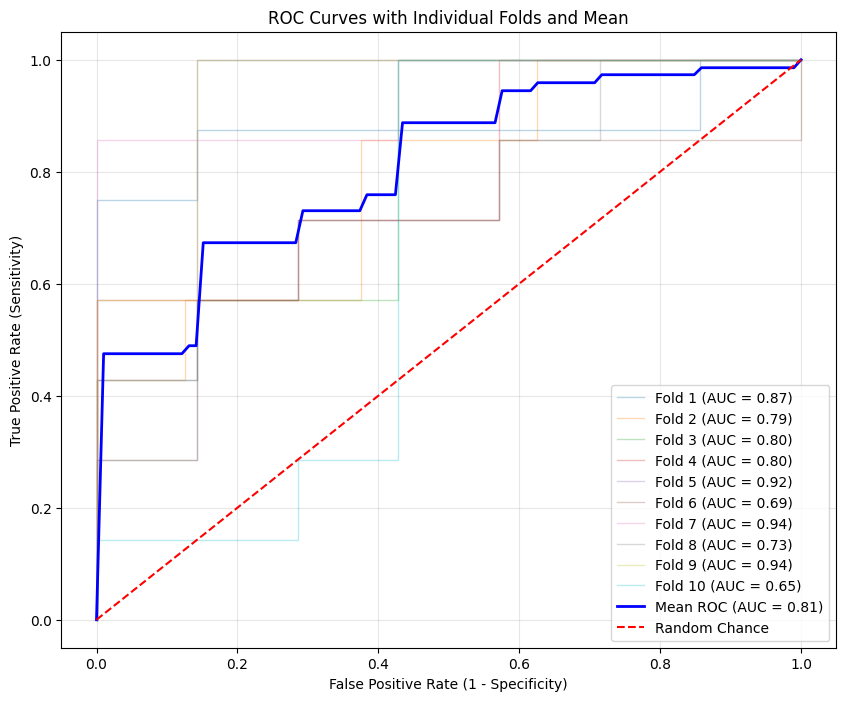

In [9]:
decision_function = best_model.decision_function(X_selected)

plt.figure(figsize=(10, 8))
# Compute ROC curve data
mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []

# Perform stratified k-fold cross-validation
for i, (train_index, test_index) in enumerate(final_skf.split(X, y)):
    # Using NumPy indexing to access training and testing sets
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train the model
    best_model.fit(X_train, y_train)

    # Get decision function scores
    decision_function = best_model.decision_function(X_test)

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, decision_function)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0

    # Plot ROC curve for this fold
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f'Fold {i+1} (AUC = {roc_auc:.2f})')


# Compute mean TPR and AUC
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

# Plot mean ROC curve
plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f})', lw=2)

# Plot the random chance line
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random Chance')

plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curves with Individual Folds and Mean')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()


This `AUC` value indicates that the logistic regression model has a good but slightly lower discriminative performance compared to an ideal classifier. It’s slightly lower than the `AUC` from the `SVM` model.

Most folds exhibit solid `AUC` values (greater than 0.80), showing consistent performance across folds, though Fold 10 is an outlier with weaker performance.

Similar to the `SVM` model, there is some variability in performance between folds, with the `AUC` ranging from 0.65 to 0.94. However, the variability appears slightly smaller.